# Mountain Car

###  Code for Mountain Car 

This implementation is based on the problem description given in [Example 8.2](http://www.incompleteideas.net/book/ebook/node89.html) of Sutton & Barto (1998) The following cells in this section will walk you through the basic usage of this class.

We import the mountaincar module and create a `MountainCar` object called `env`. The `reset()` method chooses a random starting `position` and starting `velocity` for the car, and sets the `game_over` variable to `False`. You can access these state variables independently using the same names.

In [1]:
import numpy as np
import mountaincar

np.random.seed(7)

env = mountaincar.MountainCar()
env.reset()
print("Starting position of the car", env.position)
print("Starting velocity of the car", env.velocity)
state = (env.position,env.velocity)
print(state)
if not env.game_over:
    print("Game is not over yet.")

Starting position of the car -0.454704306550481
Starting velocity of the car 0.03128512489633177
(-0.454704306550481, 0.03128512489633177)
Game is not over yet.


We can visualize the current position of the car using the `plot()` method.

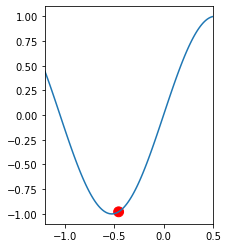

In [2]:
env.plot()

We can interact with the `MountainCar` environment using the `make_step()` method. This method takes an `action` as input and computes the response of the environment. This method returns a `reward` signal, which is always -1.

The action can be one of the following integers:
* -1: full throttle reverse
*  0: zero throttle
*  1: full throttle forward

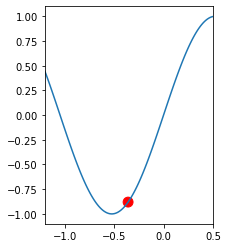

In [3]:
# Let's drive a bit full throttle forward and plot again.
print(env.make_step(action=1))
env.make_step(action=1)
env.make_step(action=1)
env.plot()

The following code snippet shows that even at full throttle the car cannot accelerate up the steep slope.

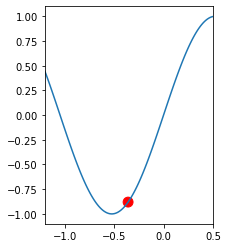

In [4]:
num_steps = 150
for episode in range(num_steps):
    # Always action 1 (full throttle forward)
    env.plot()

The pseudo-code for  _Linear, gradient-descent Sarsa($\lambda$)_ is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, [Section 8.4](http://www.incompleteideas.net/book/ebook/node89.html#fig:FAsarsa).
<img src="images/gradient_descent_Sarsa.png" style="width: 500px;"/>

In [5]:
import numpy as np
import mountaincar

import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(7)

env = mountaincar.MountainCar()
env.reset()


def makeTiles():
    
    #creating the tiles used for feature extraction
    
    #define extreme states
    
    maxPos = 0.5
    minPos = -1.2
   
    minVel = -0.07
    maxVel = 0.07
    
    numTiles = 10
    tileDim = 8
    numActions = 3

   
    #width of individual tiles
    posWidth = (maxPos - minPos) / tileDim

    velWidth = (maxVel - minVel) / tileDim


    #base tiles for position and velocity

    strtPosTile = np.linspace(minPos, maxPos+posWidth, tileDim+1)

    strtVelTile = np.linspace(minVel, maxVel+velWidth, tileDim+1)

    allTiles = []  

    # create 10 offseting tiles for each action

    for i in range(numActions):

        posCopy = [np.copy(strtPosTile)]

        velCopy = [np.copy(strtVelTile)]

    

        for i in range(numTiles-1):

            posOff = np.random.uniform(0, posWidth)

            velOff = np.random.uniform(0, velWidth)

            posCopy.append(strtPosTile - posOff)

            velCopy.append(strtVelTile - velOff)
            
        #append tiles together

        allTiles.append((posCopy, velCopy))
 

    return allTiles

    

def getFeatures(tiles, state, action):
    
    #returns features (tiling) corresponding to state of car for a particular action
    
    #return tiles for choosen action
    

    posTiles, velTiles = tiles[action+1]
    

    featuresList = []

    # Loop through tiles and find corresponding tile bin for state (postion and velocity)

    for i in range(len(posTiles)):
        
        
        posCount = 0
        for j in posTiles[i]:
            if j > state[0]:
                posTile = posCount
                break
            posCount+= 1
            
        velCount = 0
        for j in velTiles[i]:
            if j > state[1]:
                velTile = velCount
                break
            velCount+= 1
 
        featuresList.append((posTile, velTile))

   

    return featuresList




def sumTheta(theta, features, action):
 
    #return sum of theta for all features on

        
    tilings = 10
    
    numActions = 3
    
    
    numTiles = 81


    totalTheta = 0

 

    # Loop through each feature and find corresponding theta value

    for i in range(len(features)):

        pos, vel = features[i]

        index = np.ravel_multi_index([pos, vel], (9, 9))

        index += (numTiles*i) + ((action+1)*(numTiles*tilings))

        totalTheta += theta[index]

    

    return totalTheta



def learn(episodes, trace="R", epsilon = 0, lam = 0.7 ):

    #learns using sarsa gradient descent

    alpha=0.1
    
    gamma=1
    

    tiles = makeTiles()

    numActions = 3

    
    tilings = 10
    

    numTiles = 81
    
    #total number of states
    

    numStates = numActions*numTiles*tilings
    
    
    theta = np.zeros(numStates)
    rewardsList = []
    

    # Run number of episodes for learning

    for _ in range(episodes):
        
        
        env.reset()

        totalReward = 0

        eligibility = np.zeros(numStates)

        state = (env.position, env.velocity)

        actionChoice = np.random.choice(env.actions)
        
        #extract features based on state and action

        features = getFeatures(tiles, state, actionChoice)



        # keep playing until game over

        while not env.game_over:

            #loop through each feature
            for i in range(len(features)):

                #extract index of tile to corresponding 1 d q table

                pos, vel = features[i]
                
                index = np.ravel_multi_index([pos, vel], (9, 9))


                index += (numTiles*i) + ((actionChoice+1)*(numTiles*tilings))
                
                #use accumulate or replace traces. replace is default generally has better performance in practice

                if trace == "A":

                    eligibility[index] += 1

                elif trace == "R":

                    eligibility[index] = 1

                    

            # Take action and observe next state and reward
            

            reward = env.make_step(action=actionChoice)

            state = (env.position, env.velocity)

            delta = reward - sumTheta(theta, features, actionChoice)
            
#             env.plot()
            
            #choose epsilon greedy action

            if (np.random.uniform(0,1) >= epsilon):

                Qlist = []
                
                #check all actions extract the qvalues 
                for action in env.actions:
                    #new features for each eaction

                    features = getFeatures(tiles, state, action)

                    Qlist.append(sumTheta(theta, features, action))

                # choose maximum action
                
                maxQ = np.argmax(Qlist)

                actionChoice = env.actions[maxQ]

                features = getFeatures(tiles, state, actionChoice)

                Q_action = sumTheta(theta, features, actionChoice)



            else:
                #explore

                actionChoice = np.random.choice(env.actions)

                features = getFeatures(tiles, state, actionChoice)

                Q_action = sumTheta(theta, features, actionChoice)

            #update delta, theta, eligibility

            delta += (gamma * Q_action)

            theta += (alpha * delta * eligibility)

            eligibility *= (gamma*lam)


            totalReward += reward



        rewardsList.append(totalReward)

    

    return rewardsList


def singleLearning():

    #plot results for single agent

    
    rewards = learn(episodes = 1000,epsilon = 0.1)
    
    plt.figure(figsize = (12,8))

    plt.plot(rewards)

    plt.title("Learning for single agent - LGD Sarsa Lambda")

    plt.xlabel("Episode number")

    plt.ylabel("Reward")



def averageLearning(agents=20):

    #plots results for multiple agents      

    AvgRewardsList = []

    

    for i in range(agents):
        
        rewards = learn(episodes = 3000,epsilon = 0.1)

        AvgRewardsList.append(rewards)


    AvgRewardsList = np.mean(AvgRewardsList, axis = 0)

    
    plt.figure(figsize = (12,8))
    plt.plot(AvgRewardsList)

    plt.title("20 agents LGD Sarsa")

    plt.xlabel("Episode number")

    plt.ylabel("Reward")

    



In [ ]:
singleLearning()

In [ ]:
averageLearning()

Next we will use the Watkins q (lambda) algorithm. This is an off policy temporal difference control algorithm and relative to on policy TD control algorithm such as SARSA q (lambda), is more suitable for the mountain car problem. It is conceptually similar to the SARSA q (lambda) algorithm except in how it updates the Q values. In Watkins q learning the action with maximum Q value is used to update the action-value function whereas with SARSA the action chosen from the policy e.g. epsilon greedy is used. This has the following implications.
+ 1)	Q learning always learns the optimum policy whereas SARSA considers the possibility of random exploration so generally learns a near optimal policy
+ 2)	SARSA is more conservative as it considers possible penalties from exploratory moves, which Q – learning ignores. This means if there is a negative reward near the optimal path Q-learning will follow the path even if this means it will trigger that negative reward whereas SARSA will be more conservative and try to avoid this even if this means taking a longer path. So in mountain car where longer paths are penalised and there is no large negative reward one would expect the Watkins Q lambda to converge to a larger reward.


In [6]:
def watQLearn(episodes, trace="R", epsilon = 0, lam = 0.7 ):

     #learns using watkins q learning
    
    alpha=0.1
        
    gamma=1
    
    rewardsList = []
 
    tiles = makeTiles()

    numActions = 3
    
    tilings = 10

    numTiles = 81
    
    #number of states
    
    numStates = numActions*numTiles*tilings
    

    theta = np.zeros(numStates)
    rewardsList = []



    for _ in range(episodes):

        env.reset()

        totalReward = 0

        eligibility = np.zeros(numStates)

        state = (env.position, env.velocity)

        actionChoice = np.random.choice(env.actions)
        
        #extract features based on state and action

        features = getFeatures(tiles, state, actionChoice)

        
        #play until game is over

        while not env.game_over:
            
            #loop through feature

            for i in range(len(features)):

               #extract index of tile to corresponding 1 d q table

                pos, vel = features[i]

                index = np.ravel_multi_index([pos, vel], (9, 9))

                index += ( numTiles*i) + ((actionChoice+1)*( numTiles*tilings))
                
                #use accumulate or replace traces. replace is default generally has better performance in practice

                if trace == "A":

                    eligibility[index] += 1

                elif trace == "R":

                    eligibility[index] = 1
        

            # Take action and observe next state and reward

            reward = env.make_step(action=actionChoice)

            state = (env.position, env.velocity)

            delta = reward - sumTheta(theta, features, actionChoice)

            

            # Update delta and theta using the max qvalue for all actions

            Qlist = []

            for action in env.actions:

                features = getFeatures(tiles, state, action)

                Qlist.append(sumTheta(theta, features, action))

            

            delta += (gamma * max(Qlist))

            theta += (alpha * delta * eligibility)

            
            # Perform the epsilon greedy action

            if (np.random.uniform(0,1) >= epsilon):

                Qlist = []

                for action in env.actions:

                    features = getFeatures(tiles, state, action)

                    Qlist.append(sumTheta(theta, features, action))

                maxQ = np.argmax(Qlist)
                actionChoice = env.actions[maxQ]

                features = getFeatures(tiles, state, actionChoice)

                eligibility *= (gamma*lam)



            else:
                #explore
                
                actionChoice = np.random.choice(env.actions)

                eligibility *= 0

            
            #return reward
            totalReward += reward

        rewardsList.append(totalReward)  

    return rewardsList


def watSingleLearn():

     #plot results for single agent
    
    rewards = watQLearn(episodes = 1000,epsilon = 0.1)
    
    plt.figure(figsize=(12,8))


    plt.plot(rewards)

    plt.title("single agent Watkins-Q")

    plt.xlabel("Episode number")

    plt.ylabel("Reward")


def watAverageLearn(agents =20):
    
    #plots results for multiple agents
    
    avgWatRewardList = []
    
    for i in range(agents):
        
        watAvgRewards = watQLearn(episodes = 1000,epsilon = 0.1)
        
        avgWatRewardList.append(watAvgRewards)
        
        print(i)
            
    avgWatRewardList = np.mean(avgWatRewardList, axis = 0)
    
    
    plt.figure(figsize=(12,8))
    
    plt.plot(avgWatRewardList)

    plt.title("20 average agents Watkins-Q")

    plt.xlabel("Episode number")

    plt.ylabel("Reward")
        




In [ ]:
watSingleLearn()

In [ ]:
watAverageLearn()

Now we will plot the average learning curve for the two agents. 

In [7]:
def allPlots(agents=20):

    #plots average learning vcurves for both sarsa and watkins


    avgWatRewardsList = []

    avgSarsaRewardsList = []

    

    for i in range(agents):

        sarsaAvgReward = learn(episodes = 3000,epsilon = 0.1)

        watAvgRewards = watQLearn(episodes = 3000,epsilon = 0.1)


        

        avgSarsaRewardsList.append(sarsaAvgReward)

        avgWatRewardsList.append(watAvgRewards)


        

    avgSarsaRewardsList = np.mean(avgSarsaRewardsList, axis = 0)

    avgWatRewardsList = np.mean(avgWatRewardsList, axis = 0)



    plt.figure(figsize=(12,8))

    plt.plot(avgSarsaRewardsList, label='SARSA LGD')

    plt.plot(avgWatRewardsList, label = 'watkins Q')



    plt.title("Average learning for watkins q and Sarsa")

    plt.xlabel("Episode number")

    plt.ylabel("Reward")

    plt.legend()
    
    plt.show()

    




In [ ]:
averageLearning()

In [ ]:
watSingleLearn()

In [ ]:
watAverageLearn()

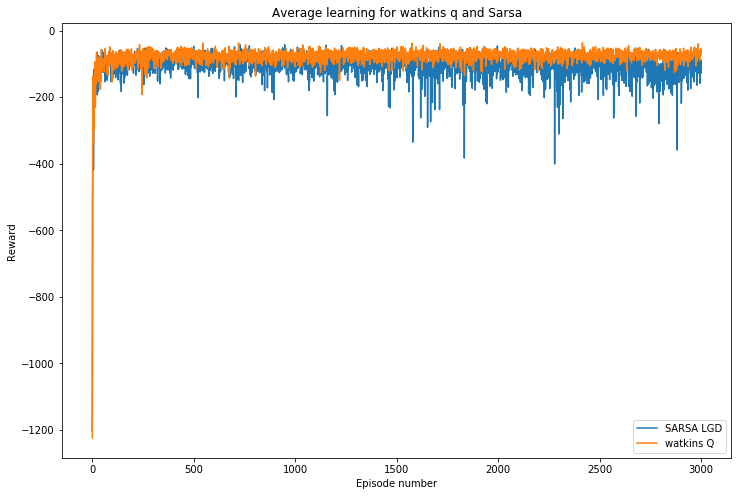

In [8]:
allPlots(agents=20)

The graph shows Watkin’s Q(λ) algorithm was much more stable with less spikes and converging to a higher reward. This was expected due to the constant low cost, fast iterating environment of the mountain car problem.